
Copyright 2023 Ian Housman

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.


* Example of the functionality of gee2Pandas module
* Use this module to go between local data and GEE for more general data science/statistical analysis

In [1]:
# Import Modules
import geeViz.getImagesLib as gil
import  geeViz.foliumView as fv
import geeViz.gee2Pandas as g2p
import pandas as pd
import matplotlib.pyplot as plt
import numpy
ee = fv.ee

# Choose whether to use Folium-based map or geeView (syntax remains the same)
# Map = fv.foliumMapper()
Map = gil.Map

Map.port = 1233
print('done')

Initializing GEE
geeViz package folder: c:\Python310\lib\site-packages\geeViz
PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.
done


In [2]:
# Set up study area and bring in some Sentinel 2 data for pre and post years
Map.clearMap()
# Map.setMapArg('tiles',"cartodb positron")
studyArea = ee.Geometry.Polygon(
        [[[-113.21807278537877, 41.786028237932015],
          [-113.21807278537877, 40.595571243156144],
          [-111.82280911350377, 40.595571243156144],
          [-111.82280911350377, 41.786028237932015]]], None, False)

preYear = 2022
postYear = 2023
startJulian = 140
endJulian = 160
s2s  = gil.getProcessedSentinel2Scenes(studyArea,preYear-1,postYear+1,startJulian,endJulian)
post = s2s.filter(ee.Filter.calendarRange(postYear,postYear,'year')).median()
postWater = gil.simpleWaterMask(post).rename(['Water'])
post = post.addBands(postWater)

Map.addLayer(post,gil.vizParamsFalse,'S2 Median {}'.format(postYear),False)
Map.addLayer(postWater,{'palette':'888,00F'},'S2 Water {}'.format(postYear))
pre = s2s.filter(ee.Filter.calendarRange(preYear,preYear,'year')).median()
preWater = gil.simpleWaterMask(pre).rename(['Water'])
pre = pre.addBands(preWater)

waterTransitionClasses=preWater.add(1).multiply(10).add(postWater).rename('Water_Transition_{}-{}'.format(preYear,postYear))
Map.addLayer(waterTransitionClasses,{'min':1,'max':21,'palette':'0F0,00F'},'Water_Transition_{}-{}'.format(preYear,postYear))
Map.addLayer(pre,gil.vizParamsFalse,'S2 Median {}'.format(preYear))
Map.addLayer(preWater,{'palette':'888,00F'},'S2 Water {}'.format(preYear))
Map.centerObject(studyArea)

Map.addLayer(studyArea,{'strokeColor':'F00','strokeWidth':10},'Study Area')
# print(Map.mapArgs)
Map.view()

Get Processed Sentinel2: 
Start date: May 20 2021 , End date: Jun 08 2024
startYear :  2021
endYear :  2024
startJulian :  140
endJulian :  160
applyQABand :  False
applyCloudScore :  False
applyShadowShift :  False
applyTDOM :  True
performCloudScoreOffset :  True
cloudScorePctl :  10
zScoreThresh :  -1
shadowSumBands :  ['nir', 'swir1']
resampleMethod :  aggregate
convertToDailyMosaics :  True
applyCloudProbability :  True
preComputedCloudScoreOffset :  None
preComputedTDOMIRMean :  None
preComputedTDOMIRStdDev :  None
origin :  Sentinel2
wrapOffset :  0
cloudProbThresh :  40
cloudScoreThresh :  20
toaOrSR :  TOA
Using S2 Collection: COPERNICUS/S2_HARMONIZED
Joining pre-computed cloud probabilities from: COPERNICUS/S2_CLOUD_PROBABILITY
Setting to aggregate instead of resample 
Converting S2 data to daily mosaics
Apply Cloud Probability
Applying TDOM
Computing irMean for TDOM
Computing irStdDev for TDOM
Adding layer: S2 Median 2023
Adding layer: S2 Water 2023
Adding layer: Water_Trans

In [3]:
# Format a stack raster and get a csv local table
nSamples = 500
Map.clearMap()
preBns = pre.bandNames().map(lambda bn:ee.String(bn).cat('_yr{}_jd{}-{}'.format(preYear,startJulian,endJulian)))
postBns = post.bandNames().map(lambda bn:ee.String(bn).cat('_yr{}_jd{}-{}'.format(postYear,startJulian,endJulian)))
stack = pre.rename(preBns).addBands(post.rename(postBns)).addBands(waterTransitionClasses)
sample =ee.FeatureCollection.randomPoints(studyArea, nSamples, 0, 50)

Map.addLayer(sample.map(lambda f:ee.Feature(f).buffer(10).bounds()),{},'Sample')


out_csv = r'C:\tmp\gee2Pandas_test_csv.csv'
g2p.geeToLocalZonalStats(sample,stack,out_csv,reducer=ee.Reducer.first(),scale=10,crs='EPSG:5070',transform=None,tileScale=4,overwrite=True,maxNumberOfFeatures=5000)
Map.view()

Adding layer: Sample
Converting featureCollection to json: gee2Pandas_test_csv.json
Starting webmap
Using default refresh token for geeView: C:\Users\ihousman/.config/earthengine/credentials
Local web server at: http://localhost:1233/geeView/ already serving.
cwd a:\GEE\gee_py_modules_package\geeViz\examples


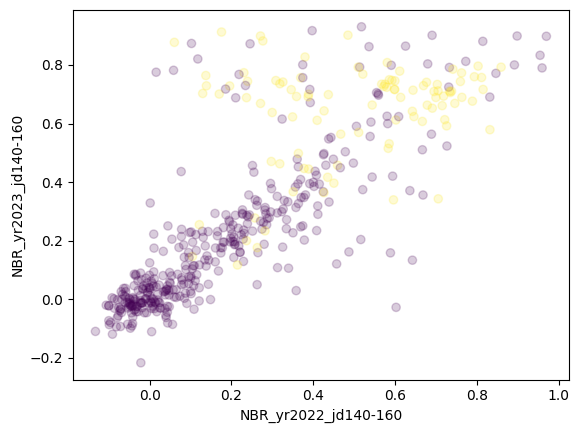

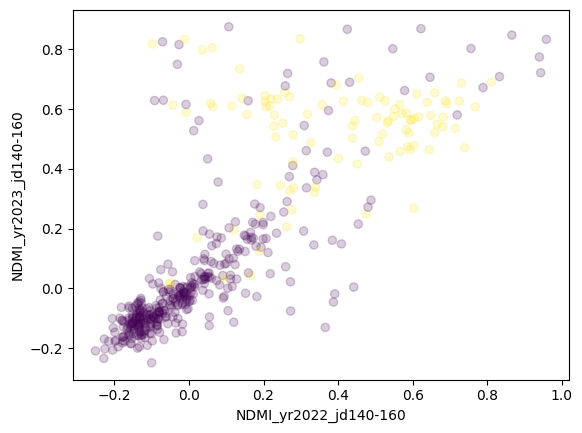

In [5]:
# Visualize xy scatter of pre and post years for some bands
t = pd.read_csv(out_csv)
plotBandNames = ['NBR','NDMI']
for plotBandName in plotBandNames:
    preColumn = '{}_yr{}_jd{}-{}'.format(plotBandName,preYear,startJulian,endJulian)
    postColumn = '{}_yr{}_jd{}-{}'.format(plotBandName,postYear,startJulian,endJulian)
    waterColumn = 'Water_yr{}_jd{}-{}'.format(postYear,startJulian,endJulian)
    # display(t)
    columns = t.columns

    fig, ax = plt.subplots()
    scat = ax.scatter(t[preColumn],t[postColumn],c=t[waterColumn],alpha=0.2)
    ax.set_xlabel(preColumn)
    ax.set_ylabel(postColumn)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    plt.show()


In [10]:
# Now go from a local csv to a GEE featureCollection
fc = g2p.tableToFeatureCollection(out_csv)
print(fc.first().getInfo())
Map.clearMap()
Map.addLayer(fc.map(lambda f:ee.Feature(f).buffer(10).bounds()),{},'Test Sample')
Map.turnOnInspector()
Map.centerObject(fc)
Map.view()

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-112.22488689511812, 41.05892928752082]}, 'id': '0', 'properties': {'ID': 0, 'NBR_yr2022_jd140-160': 0.7031987905502319, 'NBR_yr2023_jd140-160': 0.7334120869636536, 'NDCI_yr2022_jd140-160': 0.0951059758663177, 'NDCI_yr2023_jd140-160': -0.0659213736653328, 'NDMI_yr2022_jd140-160': 0.5660930275917053, 'NDMI_yr2023_jd140-160': 0.6154418587684631, 'NDSI_yr2022_jd140-160': 0.8247419595718384, 'NDSI_yr2023_jd140-160': 0.8681382536888123, 'NDVI_yr2022_jd140-160': -0.321634978055954, 'NDVI_yr2023_jd140-160': -0.4360703527927398, 'QA60_yr2022_jd140-160': 0, 'QA60_yr2023_jd140-160': 0, 'Water_Transition_2022-2023': 21, 'Water_yr2022_jd140-160': 1, 'Water_yr2023_jd140-160': 1, 'blue_yr2022_jd140-160': 0.0987450927495956, 'blue_yr2023_jd140-160': 0.112457126379013, 'brightness_yr2022_jd140-160': 0.1309919506311416, 'brightness_yr2023_jd140-160': 0.127576470375061, 'cb_yr2022_jd140-160': 0.1186233609914779, 'cb_yr2023_jd140-160': 0.1